# Replication of Paper Results

In [207]:
import numpy as np
from scipy.integrate import solve_ivp
import csv
import os

In [208]:
# m_ball = 10 #kg
# m_plate = 10 #kg

m_payload = 10

n_drones = 3
m_drones = 70 #kg
m_ball = 70


g = 9.81

length_rest = 1

In [209]:
import numpy as np

def create_multi_agent_dynamics_with_center(N, Mc, masses, L, controller, V_d, r,
                                            k=2.5e4, lambda_i=0.01, g=9.81,
                                            log_file='force_log.csv'):
    """
    """
    assert N >= 1, "There must be at least one agent (the center)."
    assert len(masses) == N

    e3 = np.array([0, 0, 1]).reshape(-1,1)
    flag = False

    # Initialize the log file
    if os.path.exists(log_file):
        os.remove(log_file)
    with open(log_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header = ['time'] + [f'f{i}_{axis}' for i in range(N) for axis in ['x', 'y', 'z']]
        writer.writerow(header)

    def dynamics(t, state):
        dstate_dt = np.zeros_like(state)
        if Mc(t) != Mc(t-1e-2):
            v_ball = 20
            print("ok")
            state[5] = (state[5]*Mc(t-1e-5) + (Mc(t)-Mc(t-1e-5))*v_ball)/Mc(t)
        
        vd = V_d(t)
        u = controller(t, state, vd)

        f = np.zeros((3, N))
        for i in range(N):
            #l_rest = state[(i+1)*6:(i+1)*6+3] - state[0:3] - r[:,i]
            #l_rest = l_rest/np.linalg.norm(l_rest)*length_rest
            f[:,i] = k*(state[(i+1)*6:(i+1)*6+3] - state[0:3] - r[:,i])

        ################################
        x_c = state[0:3]
        v_c = state[3:6]

        dxc_dt = v_c
        dvc_dt = np.sum(f, axis=1).reshape(-1,1)/Mc(t) - g*e3

        dstate_dt[0:3] = dxc_dt
        dstate_dt[3:6] = dvc_dt.flatten()

        for i in range(1, N+1):
            idx = 6 * i
            x_i = state[idx : idx + 3]
            v_i = state[idx + 3 : idx + 6]

            m_i = masses[i-1]
            F_i = u[:,i-1]
            f_i = f[:,i-1]

            dx_dt = v_i
            dv_dt = (F_i.reshape(-1,1) - f_i.reshape(-1,1) - m_i * g * e3) / m_i

            dstate_dt[idx : idx + 3] = dx_dt
            dstate_dt[idx + 3 : idx + 6] = dv_dt.flatten()

        for i in range(6*(N+1), 6*(N+1)+N):
            item = i - 6*(N+1)
            dMc_i = -lambda_i*(state[(item+1)*6+5]-vd[2])+lambda_i*np.sum([state[6*(N+1)+j]-state[6*(N+1)+item] for j in range(0, N) if L[item, j]!=0])#
            dstate_dt[i] = dMc_i

        # Log time and f_i
        with open(log_file, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            flat_f = f.T.flatten()  # shape: (3*N,) in [f1x, f1y, f1z, f2x, ...]
            writer.writerow([t] + flat_f.tolist())
            
        return dstate_dt

    return dynamics


In [210]:
class Controller():
    def __init__(self, N, Gamma_i,r, V_d, masses, alpha=np.pi/4, g=9.81, log_file='control_log.csv', f_log_file='f_hat_log.csv'):
        self.N = N
        self.Gamma_i = Gamma_i
        self.V_d = V_d
        self.masses = masses
        self.g = g
        self.log_file = log_file
        self.f_log_file = f_log_file
        self.r_norm = r / np.linalg.norm(r, axis=0, keepdims=True)
        self.alpha = alpha

        # Create or overwrite the log file and write header
        with open(self.log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['time']
            for i in range(N):
                header += [f'u{i}_x', f'u{i}_y', f'u{i}_z']
            writer.writerow(header)
        
        # Create or overwrite the force log file and write header
        with open(self.f_log_file, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['time']
            for i in range(N):
                header += [f'f{i}_x', f'f{i}_y', f'f{i}_z']
            writer.writerow(header)

    def __call__(self, t, state, vd):
        e3 = np.array([0, 0, 1]).reshape(-1,1)
        out = np.zeros((3, self.N))
        f_log = np.zeros((3, self.N))
        f_coeff = np.array([[0.0, -2.0], [2.0, 1.0], [-2.0, 1.0]])

        for i in range(self.N):
            f_hat_i = np.zeros((3,1))
            f_hat_i[2] = (1-np.exp(-t))*state[6*(self.N+1)+i]*self.g
            f_hat_i[0] = f_hat_i[2]/(np.tan(self.alpha))*self.r_norm[0,i]
            f_hat_i[1] = f_hat_i[2]/(np.tan(self.alpha))*self.r_norm[1,i]

            f_log[:, i] = f_hat_i.flatten()
            
            out[:,i] = (f_hat_i + self.masses[i]*self.g*e3 - self.Gamma_i @ (state[(i+1)*6+3:(i+1)*6+6].reshape(-1,1) - vd)).flatten() 

        # Log control input to CSV
        flat_output = out.T.flatten()  # [u0_x, u0_y, u0_z, u1_x, ...]
        with open(self.log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([t] + flat_output.tolist())
        
        # Log force estimates
        with open(self.f_log_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([t] + f_log.T.flatten().tolist())

        return out


In [ ]:
N = 3
V_d = lambda t: (1-np.exp(-t))*0.0*np.array([2,1,0]).reshape(-1,1)
Mc = lambda t: m_payload + m_ball*(t > 30)
Gamma_i = np.array([[150, 0, 0], [0, 150, 0], [0, 0, 150]])/10 #TODO:
masses = np.ones((3,1))*m_drones
L = np.array([[2, -1, -1], [-1, 1, 0], [-1, 0, 1]])
r0 =2.5
r = np.array([[0, r0, 0], [r0*np.sin(np.pi/3), -r0*np.cos(np.pi/3), 0], [-r0*np.sin(np.pi/3), -r0*np.cos(np.pi/3), 0]]).T

initial_condition = np.zeros((6*(N+1)+N))
k = 2.5e3#2.5e4
delta_zeta = m_payload * g / (k * N)
for i in range(0, 3):
    initial_condition[(i+1)*6: (i+1)*6+3] = (1 + 0.05)*r[:,i] #np.array([0, 0, delta_zeta])

initial_condition[-3:] = np.array([0.1, 0.5, 1.2])


controller = Controller(N, Gamma_i, r,  V_d, masses)

dynamics = create_multi_agent_dynamics_with_center(N, Mc, masses, L, controller, V_d, r, k=k, lambda_i=1, g=9.81)

T_sim = 100
t_eval = np.linspace(0, T_sim, 10000)
solution = solve_ivp(dynamics, (0, T_sim), initial_condition, t_eval=t_eval)

/var/folders/ny/f09pg1kd2l561c6d3m1v782r0000gn/T/ipykernel_94480/2905696850.py:66: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



ok


In [212]:
def extract_states(sol, N):
    states = sol.y
    T = states.shape[1]  # number of time steps

    positions = np.zeros((N+1, 3, T))  # includes center
    velocities = np.zeros((N+1, 3, T))
    M_values = np.zeros((N, T))

    for i in range(N+1):
        idx = 6 * i
        positions[i] = states[idx : idx + 3]
        velocities[i] = states[idx + 3 : idx + 6]

    for i in range(N):
        M_values[i] = states[6 * (N + 1) + i]

    return positions, velocities, M_values


[ 0.00000000e+00 -4.90285510e-04 -1.95748000e-03 ... -2.71891619e+01
 -2.71915078e+01 -2.71938661e+01]
[ 0.00000000e+00 -1.23459680e-08 -2.12367934e-07 ... -2.61589916e+01
 -2.61582535e+01 -2.61575110e+01]
[ 0.00000000e+00 -3.24567203e-09 -1.41523940e-07 ... -2.61589916e+01
 -2.61582535e+01 -2.61575110e+01]
[ 0.00000000e+00  1.29773983e-08 -1.27795582e-08 ... -2.61589916e+01
 -2.61582535e+01 -2.61575110e+01]


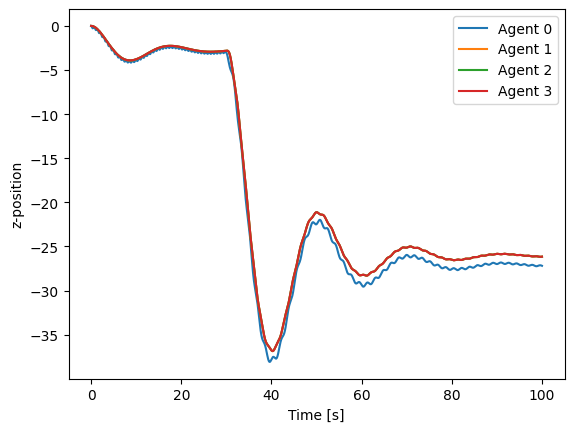

In [213]:
positions, velocities, M_values = extract_states(solution, N)

# Plot z-position of center and agents
import matplotlib.pyplot as plt
for i in range(N+1):
    print(positions[i, 2])
    plt.plot(solution.t, positions[i, 2], label=f'Agent {i}')
plt.xlabel('Time [s]')
plt.ylabel('z-position')
plt.legend()
plt.show()


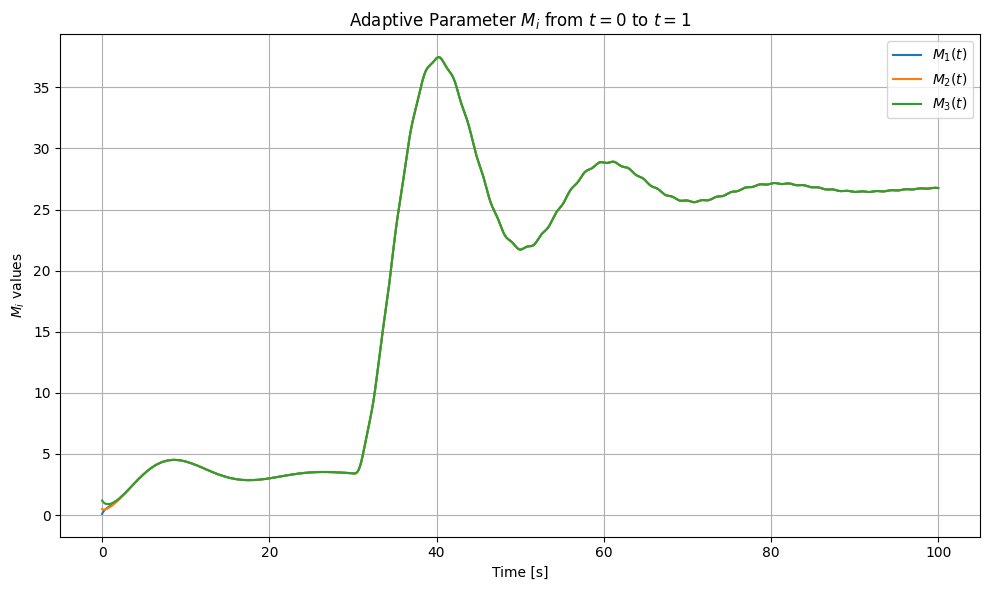

In [214]:
# Extract Mc_i values
_, _, M_values = extract_states(solution, N)

# Time vector from solve_ivp
t = solution.t

# Find indices where time is between 0 and 1
mask = (t >= 0) & (t <= T_sim)
t_filtered = t[mask]
M_filtered = M_values[:, mask]

# Plot
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(t_filtered, M_filtered[i], label=f'$M_{{{i+1}}}(t)$')

plt.xlabel('Time [s]')
plt.ylabel('$M_i$ values')
plt.title('Adaptive Parameter $M_i$ from $t=0$ to $t=1$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

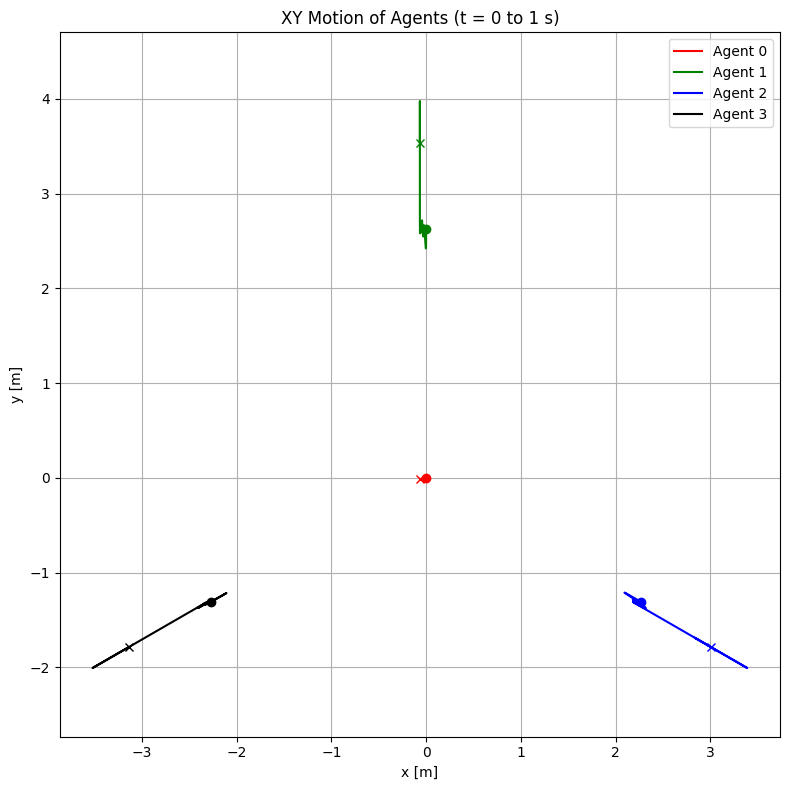

In [215]:
import matplotlib.pyplot as plt

# Assume: N = 3 agents (excluding center), so 4 total
positions, _, _ = extract_states(solution, N)

# Time range (optional): limit to 0–1 s if needed
mask = (solution.t >= 0) & (solution.t <= T_sim)
positions_xy = positions[:, :2, mask]  # shape: (N+1, 2, T)

# Plot XY trajectories
plt.figure(figsize=(8, 8))
colors = ['r', 'g', 'b', 'k']

for i in range(N+1):  # 0 = center, 1...N = agents
    x = positions_xy[i, 0, :]
    y = positions_xy[i, 1, :]
    plt.plot(x, y, color=colors[i % len(colors)], label=f'Agent {i}')
    plt.plot(x[0], y[0], 'o', color=colors[i % len(colors)])  # start point
    plt.plot(x[-1], y[-1], 'x', color=colors[i % len(colors)])  # end point

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY Motion of Agents (t = 0 to 1 s)')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()



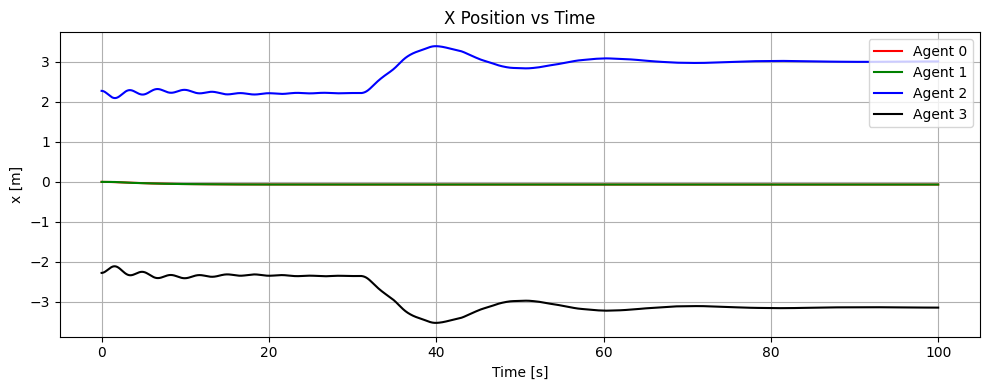

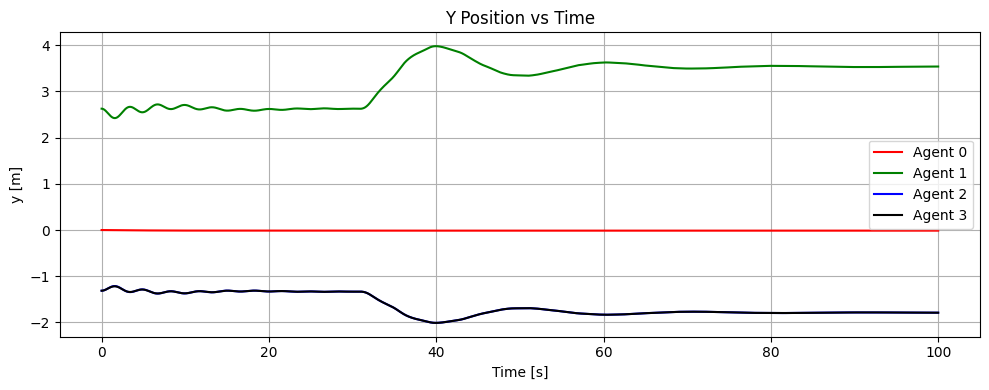

In [216]:
# Estrai dati di posizione e tempo
positions, _, _ = extract_states(solution, N)
time = solution.t
mask = (time >= 0) & (time <= T_sim)

positions = positions[:, :, mask]
time = time[mask]

colors = ['r', 'g', 'b', 'k', 'm', 'c', 'y']

# --- Plot x(t) ---
plt.figure(figsize=(10, 4))
for i in range(N+1):
    x = positions[i, 0, :]
    plt.plot(time, x, color=colors[i % len(colors)], label=f'Agent {i}')
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.title('X Position vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot y(t) ---
plt.figure(figsize=(10, 4))
for i in range(N+1):
    y = positions[i, 1, :]
    plt.plot(time, y, color=colors[i % len(colors)], label=f'Agent {i}')
plt.xlabel('Time [s]')
plt.ylabel('y [m]')
plt.title('Y Position vs Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [217]:
import plotly.graph_objs as go
import numpy as np

# Assume positions_xyz shape: (N+1, 3, T)
# positions_xyz, N, and T_sim are already defined as per your code snippet

colors = ['red', 'green', 'blue', 'black']

fig = go.Figure()

for i in range(N+1):
    x = positions[i, 0, :]
    y = positions[i, 1, :]
    z = positions[i, 2, :]
    
    # Trajectory line
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines+markers',
        name=f'Agent {i}',
        line=dict(color=colors[i % len(colors)], width=4),
        marker=dict(size=4),
        marker_symbol='circle'
    ))
    
    # Start marker (bigger circle)
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z[0]],
        mode='markers',
        marker=dict(color=colors[i % len(colors)], size=8, symbol='circle'),
        name=f'Start Agent {i}',
        showlegend=False
    ))
    
    # End marker (cross)
    fig.add_trace(go.Scatter3d(
        x=[x[-1]], y=[y[-1]], z=[z[-1]],
        mode='markers',
        marker=dict(color=colors[i % len(colors)], size=8, symbol='x'),
        name=f'End Agent {i}',
        showlegend=False
    ))

fig.update_layout(
    title='3D Motion of Agents (t = 0 to 1 s)',
    scene=dict(
        xaxis_title='x [m]',
        yaxis_title='y [m]',
        zaxis_title='z [m]',
        aspectmode='data'
    ),
    legend=dict(itemsizing='constant')
)

fig.show()

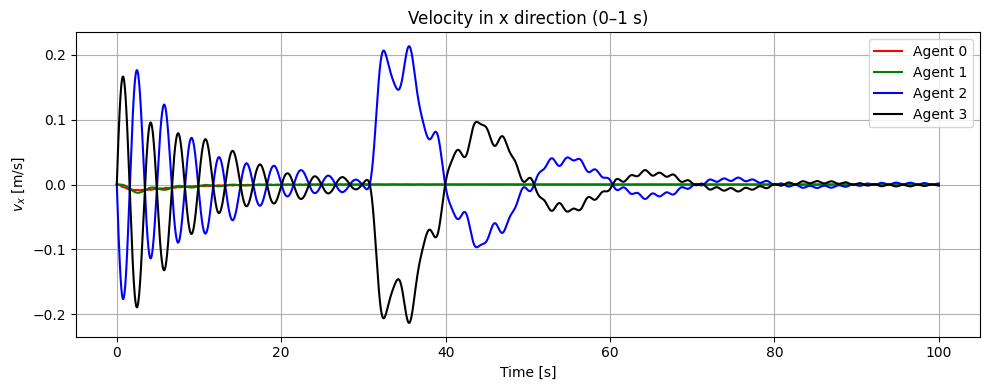

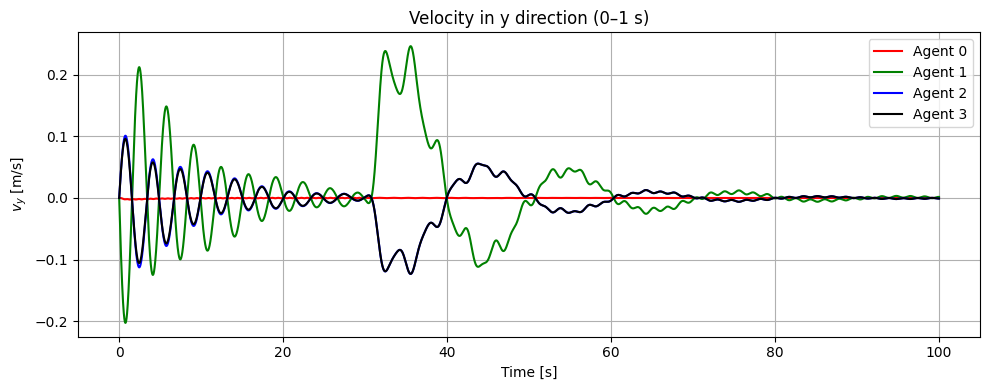

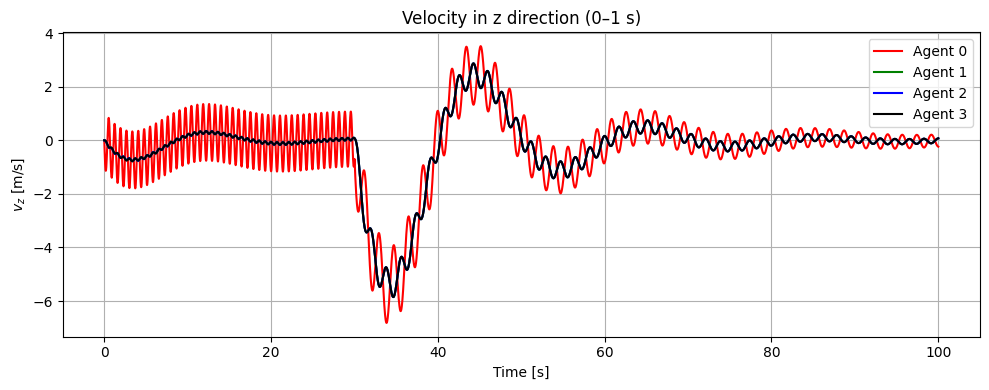

In [218]:
import matplotlib.pyplot as plt
import numpy as np

# Mask to filter time
mask = (solution.t >= 0) & (solution.t <= T_sim)
t_filtered = solution.t[mask]
velocities_filtered = velocities[:, :, mask]  # shape: (N+1, 3, T_filtered)

components = ['x', 'y', 'z']
colors = ['r', 'g', 'b', 'k', 'orange', 'purple', 'cyan']

# Plot vx, vy, vz over [0, 1] s
for dim in range(3):  # 0=x, 1=y, 2=z
    plt.figure(figsize=(10, 4))
    for i in range(N+1):
        plt.plot(t_filtered, velocities_filtered[i, dim, :], label=f'Agent {i}', color=colors[i % len(colors)])
    plt.title(f'Velocity in {components[dim]} direction (0–1 s)')
    plt.xlabel('Time [s]')
    plt.ylabel(f'$v_{components[dim]}$ [m/s]')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


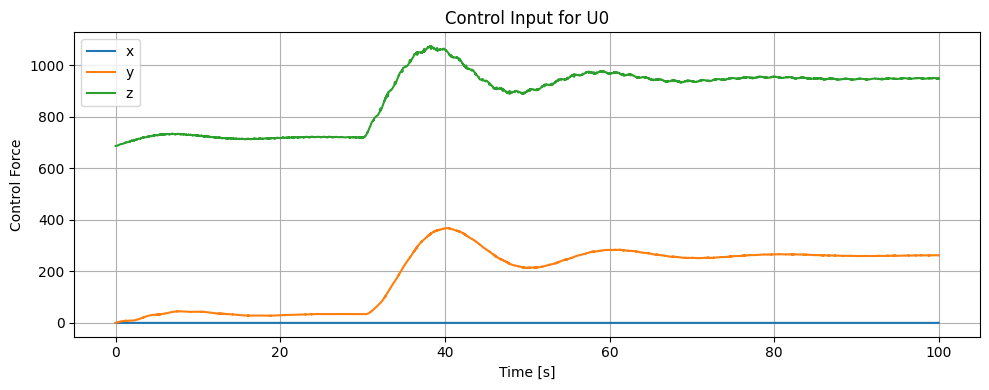

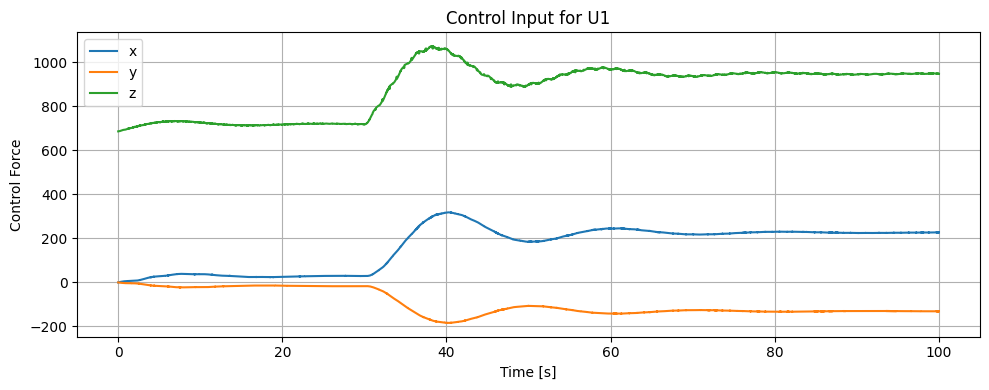

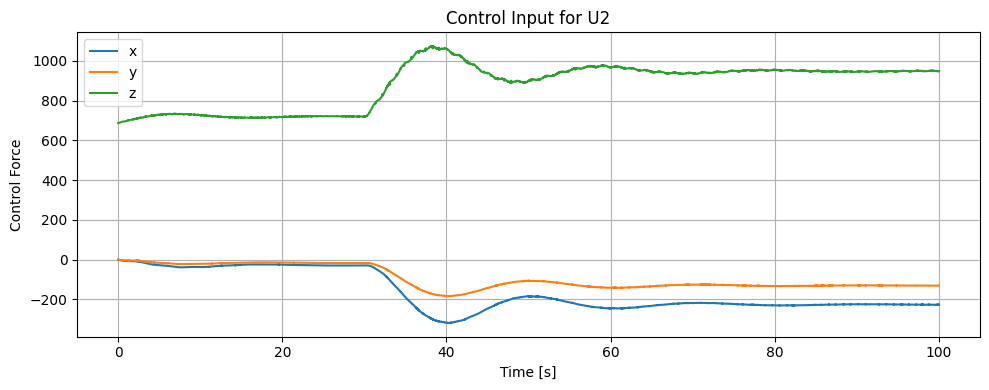

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log
df = pd.read_csv('control_log.csv')

# Extract time
time = df['time']

# Identify how many agents by parsing columns
agent_ids = sorted(set(col.split('_')[0] for col in df.columns if col != 'time'))

# Plot control inputs for each agent
for agent_id in agent_ids:
    plt.figure(figsize=(10, 4))
    plt.plot(time, df[f'{agent_id}_x'], label='x')
    plt.plot(time, df[f'{agent_id}_y'], label='y')
    plt.plot(time, df[f'{agent_id}_z'], label='z')
    plt.title(f'Control Input for {agent_id.upper()}')
    plt.xlabel('Time [s]')
    plt.ylabel('Control Force')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


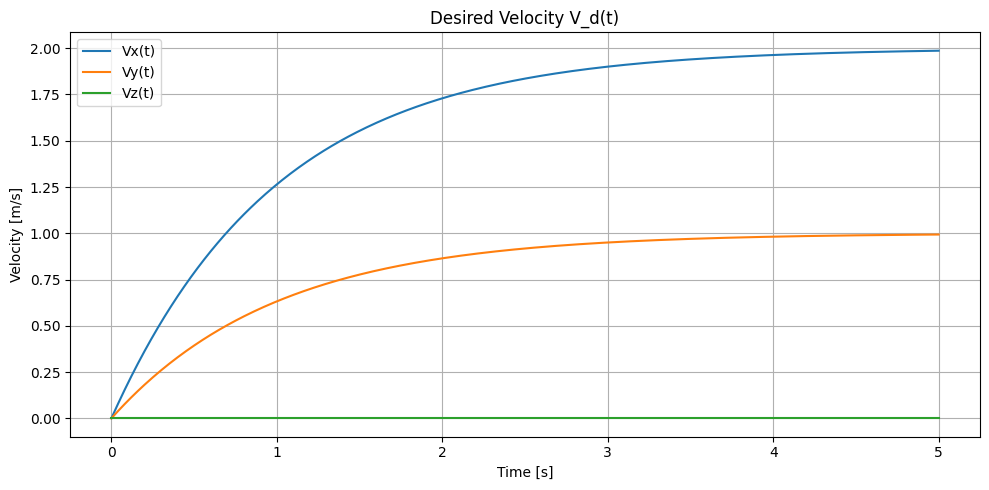

In [220]:
import numpy as np
import matplotlib.pyplot as plt

# Define V_d(t)
V_d = lambda t: (1 - np.exp(-t)) * np.array([2.0, 1.0, 0.0])

# Time vector
t_vals = np.linspace(0, 5, 500)
Vx = []
Vy = []
Vz = []

# Compute components over time
for t in t_vals:
    v = V_d(t)
    Vx.append(v[0])
    Vy.append(v[1])
    Vz.append(v[2])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t_vals, Vx, label='Vx(t)')
plt.plot(t_vals, Vy, label='Vy(t)')
plt.plot(t_vals, Vz, label='Vz(t)')
plt.title('Desired Velocity V_d(t)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


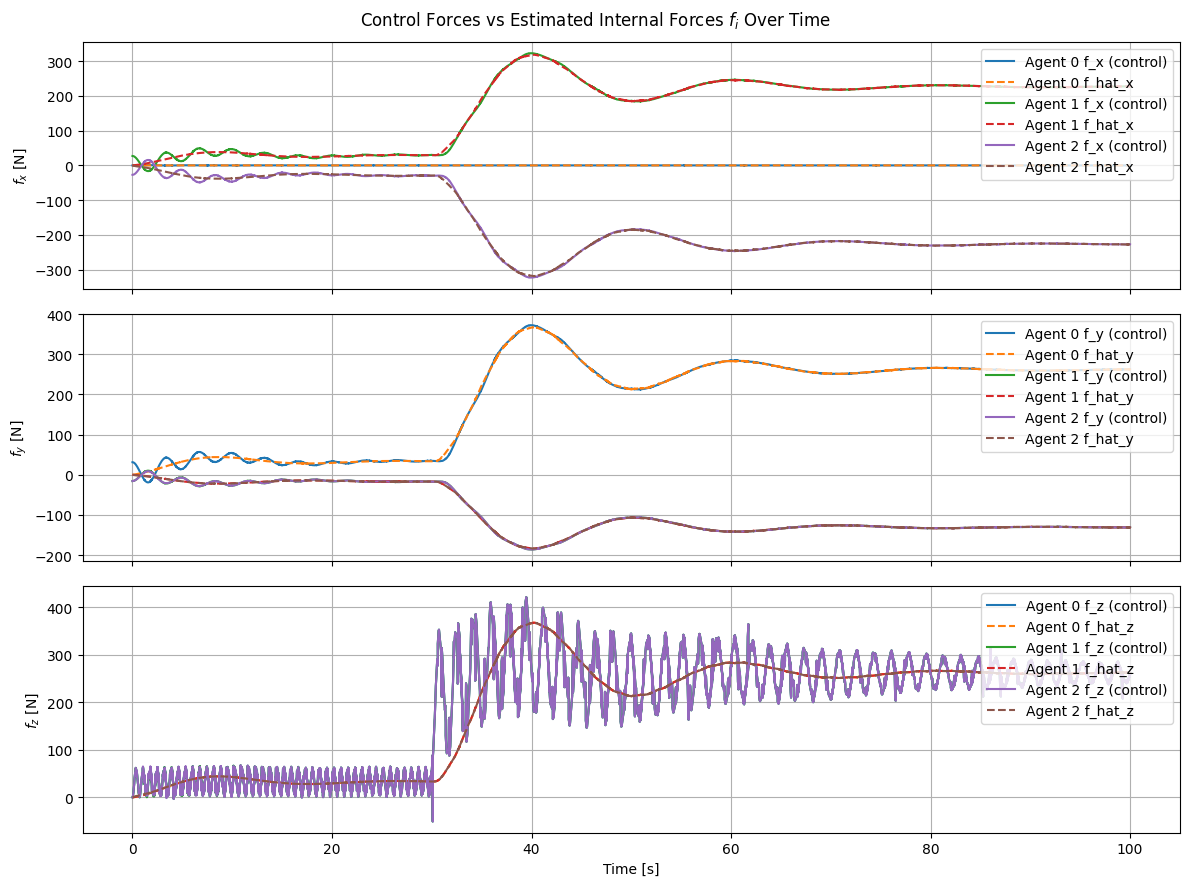

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the logged data
df_control = pd.read_csv('force_log.csv')   # control forces
df_f_hat = pd.read_csv('f_hat_log.csv')         # estimated internal forces

# Extract only the first 10 timesteps
#df_control = df_control.iloc[:100]
#df_f_hat = df_f_hat.iloc[:100]

# Extract time and number of agents
time = df_control['time']
N = (df_control.shape[1] - 1) // 3
components = ['x', 'y', 'z']

# Plot each component for each agent
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

for i, comp in enumerate(components):
    for agent in range(N):
        # Plot actual control forces
        axs[i].plot(time, df_control[f'f{agent}_{comp}'], label=f'Agent {agent} f_{comp} (control)', linestyle='-')
        # Plot estimated forces
        axs[i].plot(time, df_f_hat[f'f{agent}_{comp}'], label=f'Agent {agent} f_hat_{comp}', linestyle='--')
    
    axs[i].set_ylabel(f'$f_{comp}$ [N]')
    axs[i].grid(True)
    axs[i].legend(loc='upper right')

axs[2].set_xlabel('Time [s]')
fig.suptitle('Control Forces vs Estimated Internal Forces $f_i$ Over Time')
plt.tight_layout()
plt.show()




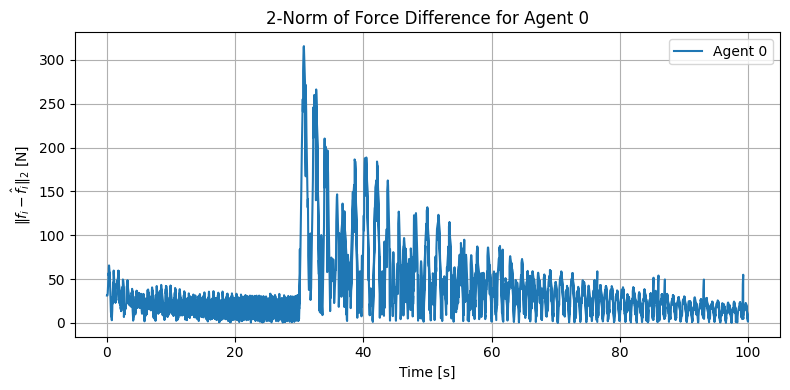

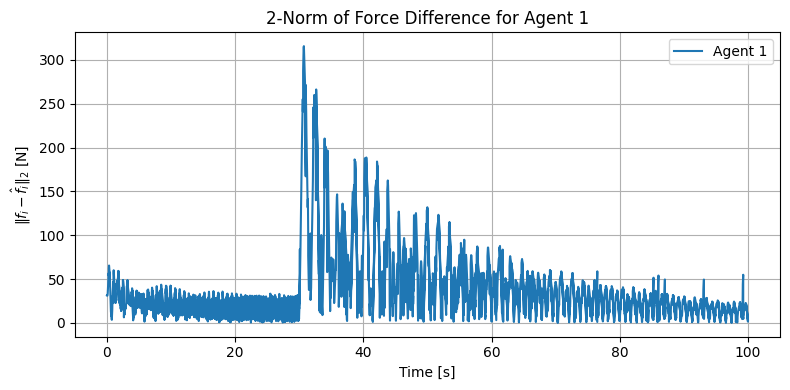

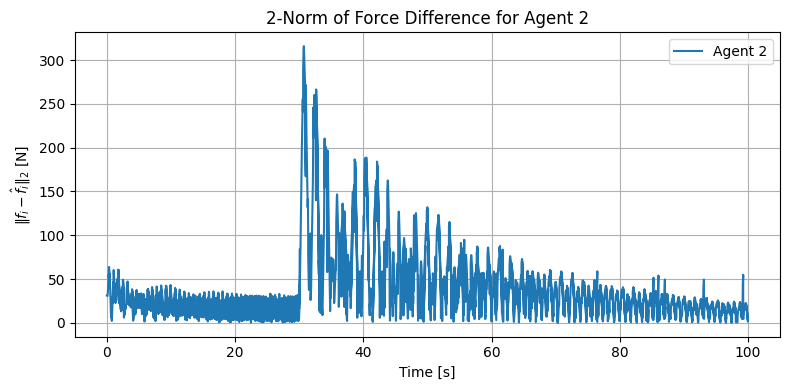

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df_control = pd.read_csv('force_log.csv')
df_f_hat = pd.read_csv('f_hat_log.csv')

# Extract time and number of agents
time = df_control['time']
N = (df_control.shape[1] - 1) // 3
components = ['x', 'y', 'z']

# Compute 2-norm of the difference between control forces and estimated forces
for agent in range(N):
    diff_sq = np.zeros(len(time))
    for comp in components:
        f = df_control[f'f{agent}_{comp}']
        f_hat = df_f_hat[f'f{agent}_{comp}']
        diff_sq += (f - f_hat)**2

    norm = np.sqrt(diff_sq)

    # Create a separate plot for each agent
    plt.figure(figsize=(8, 4))
    plt.plot(time, norm, label=f'Agent {agent}')
    plt.title(f'2-Norm of Force Difference for Agent {agent}')
    plt.xlabel('Time [s]')
    plt.ylabel('$\\|f_i - \\hat{{f}}_i\\|_2$ [N]')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
